In [ ]:
import torch
import torch.nn as nn
from torch.nn.functional import relu
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.amp import GradScaler
from collections import  Counter
import torch.optim as optim
import gc
import cv2
import copy
import random
import os
from pathlib import Path
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
import warnings 
warnings.filterwarnings("ignore")

In [2]:
dataset_path = Path("/kaggle/input/lgg-mri-segmentation")

In [3]:
image_paths = []
mask_paths = []

for image_path in glob.glob(f"{dataset_path}/**/*.tif", recursive=True):
    if not image_path.endswith("_mask.tif"):  
        mask_path = image_path.replace(".tif", "_mask.tif")
        if os.path.isfile(mask_path): 
            image_paths.append(image_path)
            mask_paths.append(mask_path)

df = pd.DataFrame({"image": image_paths, "mask": mask_paths})
print(f"Count of images: {len(image_paths)}")
print(f"Count of masks: {len(mask_paths)}")

Count of images: 7858
Count of masks: 7858


## EDA

In [4]:
print("Duplicate image paths:", df["image"].duplicated().sum())
print("Duplicate mask paths:", df["mask"].duplicated().sum())


Duplicate image paths: 0
Duplicate mask paths: 0


In [5]:
image_shapes = []
for img_path in df["image"].sample(200, random_state=42):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    image_shapes.append(img.shape)

shape_counts = Counter(image_shapes)
shape_counts

Counter({(256, 256): 200})

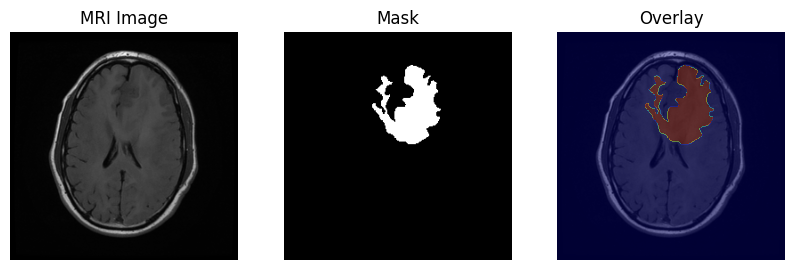

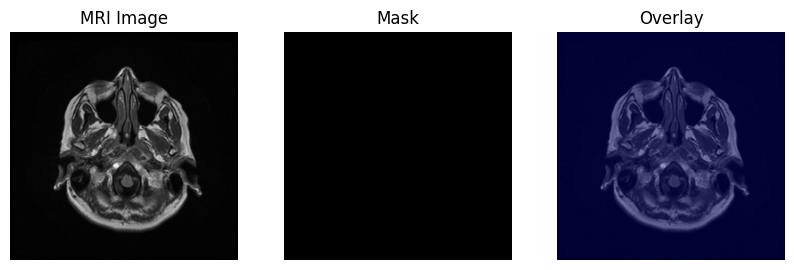

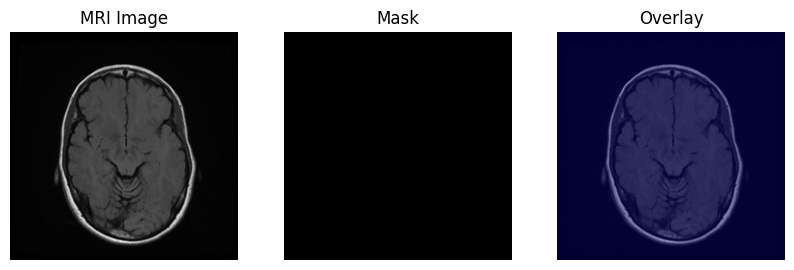

In [6]:
def visualize_sample(img_path, mask_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(10,4))

    plt.subplot(1,3,1)
    plt.title("MRI Image")
    plt.imshow(img, cmap="gray")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Mask")
    plt.imshow(mask, cmap="gray")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Overlay")
    plt.imshow(img, cmap="gray")
    plt.imshow(mask, cmap="jet", alpha=0.4)
    plt.axis("off")

    plt.show()


for idx in random.sample(range(len(df)), 3):
    visualize_sample(df.iloc[idx]["image"], df.iloc[idx]["mask"])

In [7]:
mask_values = set()

for mask_path in df["mask"].sample(200, random_state=42):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask_values.update(np.unique(mask))

sorted(mask_values)

[0, 255]

In [8]:
has_tumor = []

for mask_path in df["mask"]:
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    has_tumor.append(int(np.any(mask > 0)))

df["has_tumor"] = has_tumor

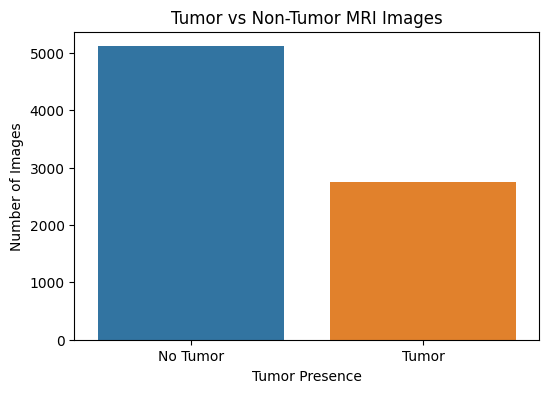

In [9]:
plt.figure(figsize=(6,4))
sns.countplot(x=df["has_tumor"])
plt.xticks([0,1], ["No Tumor", "Tumor"])
plt.xlabel("Tumor Presence")
plt.ylabel("Number of Images")
plt.title("Tumor vs Non-Tumor MRI Images")
plt.show()

In [10]:
df["has_tumor"].value_counts(normalize=True)

has_tumor
0    0.650547
1    0.349453
Name: proportion, dtype: float64

## Dataset Construction

In [11]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.ColorJitter(brightness=0.1, contrast=0.1, p=0.5),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2()
])

val_test_transform = A.Compose([
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2()
])

In [12]:
class BrainMRIDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["image"]
        mask_path = self.df.iloc[idx]["mask"]
        
        # Read image & mask
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if image is None:
            raise ValueError(f"Could not load image: {img_path}")
        if mask is None:
            raise ValueError(f"Could not load mask: {mask_path}")
        
        # Binary mask
        mask = (mask > 0).astype(np.float32)
        
        # Apply transforms
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]
        
        mask = (mask > 0.5).float()
        
        if mask.dim() == 2:
            mask = mask.unsqueeze(0)  # (1, H, W)
        
        return image, mask

In [13]:
train_val_idx, test_idx = train_test_split(
    range(len(df)), 
    test_size=0.1, 
    random_state=42
)


train_idx, val_idx = train_test_split(
    train_val_idx, 
    test_size=0.2,  
    random_state=42
)


train_df = df.iloc[train_idx].reset_index(drop=True)
val_df = df.iloc[val_idx].reset_index(drop=True)
test_df = df.iloc[test_idx].reset_index(drop=True)

print(f"\nDataset split:")
print(f"Train: {len(train_df)} samples ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation: {len(val_df)} samples ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test: {len(test_df)} samples ({len(test_df)/len(df)*100:.1f}%)")


train_dataset = BrainMRIDataset(train_df, transform=train_transform)
val_dataset = BrainMRIDataset(val_df, transform=val_test_transform)
test_dataset = BrainMRIDataset(test_df, transform=val_test_transform)


Dataset split:
Train: 5657 samples (72.0%)
Validation: 1415 samples (18.0%)
Test: 786 samples (10.0%)


## Attention

In [14]:
class SpatialAttentionModule(nn.Module):
    def __init__(self, kernel_size):
        super(SpatialAttentionModule, self).__init__()
        assert kernel_size in (3, 7), "kernel size must be 3 or 7"
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)

    def forward(self, x):
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        max_pool, _ = torch.max(x, dim=1, keepdim=True)
        cat_out = torch.cat([avg_pool, max_pool], dim=1)
        out = self.conv(cat_out)
        M = torch.sigmoid(out)
        return x * M


In [15]:
class SEBlock(nn.Module):
  def __init__(self, in_channels, reduction=16):
    super(SEBlock, self).__init__()
    reduced = max(1, in_channels // reduction)
    self.avg_global_pooling = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Conv2d(in_channels, reduced, 1)
    self.relu = nn.ReLU(inplace=True)
    self.fc_out = nn.Conv2d(reduced, in_channels, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    avg_pooling = self.avg_global_pooling(x)
    fc1 = self.fc(avg_pooling)
    relu = self.relu(fc1)
    fc2 = self.fc_out(relu)
    sigmoid = self.sigmoid(fc2)
    return x * sigmoid

In [16]:
class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = SEBlock(in_channels, reduction)
        self.spatial_attention = SpatialAttentionModule(kernel_size)

    def forward(self, x):
      x = self.channel_attention.forward(x)
      x = self.spatial_attention.forward(x)
      return x

## Model

In [17]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_p=0.2):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(p=dropout_p)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = relu(x)
        x = self.dropout(x)
        return x

class UNet(nn.Module):
    def __init__(self, n_classes, use_cbam=True, dropout_p=0.2):  
        super(UNet, self).__init__()
        self.use_cbam = use_cbam
        
        # ENCODER PART
        self.enc1_1 = ConvBlock(3, 64, dropout_p=dropout_p)
        self.enc1_2 = ConvBlock(64, 64, dropout_p=dropout_p)
        self.cbam_enc1 = CBAM(64, reduction=16) if use_cbam else None
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc2_1 = ConvBlock(64, 128, dropout_p=dropout_p)
        self.enc2_2 = ConvBlock(128, 128, dropout_p=dropout_p)
        self.cbam_enc2 = CBAM(128, reduction=16) if use_cbam else None
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc3_1 = ConvBlock(128, 256, dropout_p=dropout_p)
        self.enc3_2 = ConvBlock(256, 256, dropout_p=dropout_p)
        self.cbam_enc3 = CBAM(256, reduction=16) if use_cbam else None
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc4_1 = ConvBlock(256, 512, dropout_p=dropout_p)
        self.enc4_2 = ConvBlock(512, 512, dropout_p=dropout_p)
        self.cbam_enc4 = CBAM(512, reduction=16) if use_cbam else None
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # BOTTLENECK with higher dropout
        self.bottleneck1 = ConvBlock(512, 1024, dropout_p=dropout_p * 1.5)
        self.bottleneck2 = ConvBlock(1024, 1024, dropout_p=dropout_p * 1.5)
        self.cbam_bottleneck = CBAM(1024, reduction=16) if use_cbam else None
        
        # DECODER PART
        self.up1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec1_1 = ConvBlock(1024, 512, dropout_p=dropout_p)
        self.dec1_2 = ConvBlock(512, 512, dropout_p=dropout_p)
        self.cbam_dec1 = CBAM(512, reduction=16) if use_cbam else None
        
        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec2_1 = ConvBlock(512, 256, dropout_p=dropout_p)
        self.dec2_2 = ConvBlock(256, 256, dropout_p=dropout_p)
        self.cbam_dec2 = CBAM(256, reduction=16) if use_cbam else None
        
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec3_1 = ConvBlock(256, 128, dropout_p=dropout_p)
        self.dec3_2 = ConvBlock(128, 128, dropout_p=dropout_p)
        self.cbam_dec3 = CBAM(128, reduction=16) if use_cbam else None
        
        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec4_1 = ConvBlock(128, 64, dropout_p=dropout_p)
        self.dec4_2 = ConvBlock(64, 64, dropout_p=dropout_p)
        self.cbam_dec4 = CBAM(64, reduction=16) if use_cbam else None

        self.out = nn.Conv2d(64, n_classes, 1)
        
    def forward(self, x):
        # ENCODER PART
        xe11 = self.enc1_1(x)
        xe12 = self.enc1_2(xe11)
        if self.use_cbam:
            xe12 = self.cbam_enc1(xe12)
        pool1 = self.pool1(xe12)
        
        xe21 = self.enc2_1(pool1)
        xe22 = self.enc2_2(xe21)
        if self.use_cbam:
            xe22 = self.cbam_enc2(xe22)
        pool2 = self.pool2(xe22)
        
        xe31 = self.enc3_1(pool2)
        xe32 = self.enc3_2(xe31)
        if self.use_cbam:
            xe32 = self.cbam_enc3(xe32)
        pool3 = self.pool3(xe32)
        
        xe41 = self.enc4_1(pool3)
        xe42 = self.enc4_2(xe41)
        if self.use_cbam:
            xe42 = self.cbam_enc4(xe42)
        pool4 = self.pool4(xe42)
        
        # BOTTLENECK
        xe51 = self.bottleneck1(pool4)
        xe52 = self.bottleneck2(xe51)
        if self.use_cbam:
            xe52 = self.cbam_bottleneck(xe52)
        
        # DECODER PART
        xu1 = self.up1(xe52)
        xu1 = torch.cat((xu1, xe42), dim=1)  # skip connection
        xu11 = self.dec1_1(xu1)
        xu12 = self.dec1_2(xu11)
        if self.use_cbam:
            xu12 = self.cbam_dec1(xu12)
        
        xu2 = self.up2(xu12)
        xu2 = torch.cat((xu2, xe32), dim=1)  # skip connection
        xu21 = self.dec2_1(xu2)
        xu22 = self.dec2_2(xu21)
        if self.use_cbam:
            xu22 = self.cbam_dec2(xu22)
        
        xu3 = self.up3(xu22)
        xu3 = torch.cat((xu3, xe22), dim=1)  # skip connection
        xu31 = self.dec3_1(xu3)
        xu32 = self.dec3_2(xu31)
        if self.use_cbam:
            xu32 = self.cbam_dec3(xu32)
        
        xu4 = self.up4(xu32)
        xu4 = torch.cat((xu4, xe12), dim=1)  # skip connection
        xu41 = self.dec4_1(xu4)
        xu42 = self.dec4_2(xu41)
        if self.use_cbam:
            xu42 = self.cbam_dec4(xu42)
        
        out = self.out(xu42)
        return out

## Training

In [18]:
def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred) 
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)
    intersection = (pred * target).sum()

    loss = 1 - ((2. * intersection + smooth) / (pred.sum() + target.sum() + smooth))
    return loss


@torch.no_grad()
def dice_score_batch(pred, target, smooth=1e-6):
    pred = (torch.sigmoid(pred) > 0.5).float()
    
    pred = pred.view(pred.size(0), -1)
    target = target.view(target.size(0), -1)

    intersection = (pred * target).sum(dim=1)
    union = pred.sum(dim=1) + target.sum(dim=1)

    dice = (2. * intersection + smooth) / (union + smooth)

    return dice.mean()


In [19]:
class Trainer:
    def __init__(self, model, dataset, patience=7):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)

        self.batch_size = 16
        self.accumulation_steps = 2
        
        # Early Stopping
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_model_wts = copy.deepcopy(model.state_dict())

        self.scaler = GradScaler()


        self.bce = nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-4)

        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.1, patience=3, verbose=True
        )

    def combined_loss(self, outputs, targets):
        bce_loss = self.bce(outputs, targets)
        d_loss = dice_loss(outputs, targets)
        return 0.5 * bce_loss + 0.5 * d_loss

    def get_loader(self, dataset, shuffle=True):
        return DataLoader(
            dataset,
            batch_size=self.batch_size,
            shuffle=shuffle,
            num_workers=2,
            pin_memory=True,
            persistent_workers=True
        )

    def clean_memory(self):
        gc.collect()
        torch.cuda.empty_cache()

    def train_epoch(self, data_loader, epoch_idx):
        self.model.train()
        loss_total = 0.0

        self.optimizer.zero_grad(set_to_none=True)
        loop = tqdm(data_loader, desc=f"Epoch {epoch_idx+1} [Train]", leave=False)

        for batch_idx, (data, target) in enumerate(loop):
            data = data.to(self.device, non_blocking=True)
            target = target.to(self.device, non_blocking=True).float()

            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                output = self.model(data)
                loss = self.combined_loss(output, target)
                loss = loss / self.accumulation_steps

            self.scaler.scale(loss).backward()

            if (batch_idx + 1) % self.accumulation_steps == 0:
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad(set_to_none=True)

            loss_val = loss.item() * self.accumulation_steps
            loss_total += loss_val
            loop.set_postfix(loss=loss_val)

        if len(data_loader) % self.accumulation_steps != 0:
            self.scaler.step(self.optimizer)
            self.scaler.update()
            self.optimizer.zero_grad(set_to_none=True)
        
        self.clean_memory()

        avg_loss = loss_total / len(data_loader)
        print(f"Epoch {epoch_idx + 1} | Train Loss: {avg_loss:.4f}")
        return avg_loss

    @torch.no_grad()
    def validate_epoch(self, data_loader, epoch_idx):
        self.model.eval()

        val_loss = 0.0
        val_dice = 0.0

        loop = tqdm(data_loader, desc=f"Epoch {epoch_idx+1} [Val]", leave=False)

        for data, target in loop:
            data = data.to(self.device, non_blocking=True)
            target = target.to(self.device, non_blocking=True).float()

            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                output = self.model(data)
                loss = self.combined_loss(output, target)

            val_loss += loss.item()
            val_dice += dice_score_batch(output, target).item()
            

        val_loss /= len(data_loader)
        val_dice /= len(data_loader)
        

        self.clean_memory()

        current_lr = self.optimizer.param_groups[0]['lr']
        print(
            f"Epoch {epoch_idx + 1} | "
            f"Val Loss: {val_loss:.4f} | "
            f"Val Dice: {val_dice:.4f} | "
            f"LR: {current_lr:.6f}"
        )

        self.scheduler.step(val_loss)

        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_wts = copy.deepcopy(self.model.state_dict())
            torch.save(self.model.state_dict(), 'best_model.pth')
            print("  -> New best model saved!")
        else:
            self.counter += 1
            print(f"  -> EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

        return val_loss, val_dice

    def fit(self, train_loader, val_loader, epochs):
        for epoch in range(epochs):
            self.train_epoch(train_loader, epoch)
            self.validate_epoch(val_loader, epoch)
            
            if self.early_stop:
                print("Early stopping triggered.")
                self.model.load_state_dict(self.best_model_wts)
                break
        

        self.clean_memory()

In [20]:
model = UNet(1)
trainer = Trainer(model, train_dataset, patience=10)

train_loader = trainer.get_loader(train_dataset, shuffle=True)
val_loader = trainer.get_loader(val_dataset, shuffle=False)

trainer.fit(train_loader, val_loader, epochs=35)

Epoch 1 | Train Loss: 0.7814


Epoch 1 | Val Loss: 0.7401 | Val Dice: 0.6309 | LR: 0.000100
  -> New best model saved!


Epoch 2 | Train Loss: 0.7066


Epoch 2 | Val Loss: 0.6838 | Val Dice: 0.5839 | LR: 0.000100
  -> New best model saved!


Epoch 3 | Train Loss: 0.6538


Epoch 3 | Val Loss: 0.6386 | Val Dice: 0.6234 | LR: 0.000100
  -> New best model saved!


Epoch 4 | Train Loss: 0.6087


Epoch 4 | Val Loss: 0.5838 | Val Dice: 0.7015 | LR: 0.000100
  -> New best model saved!


Epoch 5 | Train Loss: 0.5667


Epoch 5 | Val Loss: 0.5327 | Val Dice: 0.5866 | LR: 0.000100
  -> New best model saved!


Epoch 6 | Train Loss: 0.5252


Epoch 6 | Val Loss: 0.4876 | Val Dice: 0.6971 | LR: 0.000100
  -> New best model saved!


Epoch 7 | Train Loss: 0.4843


Epoch 7 | Val Loss: 0.4401 | Val Dice: 0.5745 | LR: 0.000100
  -> New best model saved!


Epoch 8 | Train Loss: 0.4476


Epoch 8 | Val Loss: 0.3848 | Val Dice: 0.7064 | LR: 0.000100
  -> New best model saved!


Epoch 9 | Train Loss: 0.4062


Epoch 9 | Val Loss: 0.3305 | Val Dice: 0.7226 | LR: 0.000100
  -> New best model saved!


Epoch 10 | Train Loss: 0.3589


Epoch 10 | Val Loss: 0.2711 | Val Dice: 0.7746 | LR: 0.000100
  -> New best model saved!


Epoch 11 | Train Loss: 0.3195


Epoch 11 | Val Loss: 0.2432 | Val Dice: 0.7721 | LR: 0.000100
  -> New best model saved!


Epoch 12 | Train Loss: 0.3008


Epoch 12 | Val Loss: 0.2190 | Val Dice: 0.7667 | LR: 0.000100
  -> New best model saved!


Epoch 13 | Train Loss: 0.2693


Epoch 13 | Val Loss: 0.1968 | Val Dice: 0.7901 | LR: 0.000100
  -> New best model saved!


Epoch 14 | Train Loss: 0.2552


Epoch 14 | Val Loss: 0.1823 | Val Dice: 0.8139 | LR: 0.000100
  -> New best model saved!


Epoch 15 | Train Loss: 0.2414


Epoch 15 | Val Loss: 0.1645 | Val Dice: 0.8167 | LR: 0.000100
  -> New best model saved!


Epoch 16 | Train Loss: 0.2275


Epoch 16 | Val Loss: 0.1612 | Val Dice: 0.8130 | LR: 0.000100
  -> New best model saved!


Epoch 17 | Train Loss: 0.2240


Epoch 17 | Val Loss: 0.1560 | Val Dice: 0.8358 | LR: 0.000100
  -> New best model saved!


Epoch 18 | Train Loss: 0.2174


Epoch 18 | Val Loss: 0.1607 | Val Dice: 0.7898 | LR: 0.000100
  -> EarlyStopping counter: 1 out of 10


Epoch 19 | Train Loss: 0.2154


Epoch 19 | Val Loss: 0.1465 | Val Dice: 0.8400 | LR: 0.000100
  -> New best model saved!


Epoch 20 | Train Loss: 0.2129


Epoch 20 | Val Loss: 0.1572 | Val Dice: 0.8146 | LR: 0.000100
  -> EarlyStopping counter: 1 out of 10


Epoch 21 | Train Loss: 0.2078


Epoch 21 | Val Loss: 0.1491 | Val Dice: 0.8231 | LR: 0.000100
  -> EarlyStopping counter: 2 out of 10


Epoch 22 | Train Loss: 0.1996


Epoch 22 | Val Loss: 0.1460 | Val Dice: 0.8156 | LR: 0.000100
  -> New best model saved!


Epoch 23 | Train Loss: 0.2020


Epoch 23 | Val Loss: 0.1421 | Val Dice: 0.8434 | LR: 0.000100
  -> New best model saved!


Epoch 24 | Train Loss: 0.2048


Epoch 24 | Val Loss: 0.1495 | Val Dice: 0.8267 | LR: 0.000100
  -> EarlyStopping counter: 1 out of 10


Epoch 25 | Train Loss: 0.1929


Epoch 25 | Val Loss: 0.1396 | Val Dice: 0.8227 | LR: 0.000100
  -> New best model saved!


Epoch 26 | Train Loss: 0.1956


Epoch 26 | Val Loss: 0.1307 | Val Dice: 0.8449 | LR: 0.000100
  -> New best model saved!


Epoch 27 | Train Loss: 0.1863


Epoch 27 | Val Loss: 0.1331 | Val Dice: 0.8463 | LR: 0.000100
  -> EarlyStopping counter: 1 out of 10


Epoch 28 | Train Loss: 0.1928


Epoch 28 | Val Loss: 0.1317 | Val Dice: 0.8428 | LR: 0.000100
  -> EarlyStopping counter: 2 out of 10


Epoch 29 | Train Loss: 0.1760


Epoch 29 | Val Loss: 0.1262 | Val Dice: 0.8537 | LR: 0.000100
  -> New best model saved!


Epoch 30 | Train Loss: 0.1807


Epoch 30 | Val Loss: 0.1316 | Val Dice: 0.8406 | LR: 0.000100
  -> EarlyStopping counter: 1 out of 10


Epoch 31 | Train Loss: 0.1804


Epoch 31 | Val Loss: 0.1340 | Val Dice: 0.8377 | LR: 0.000100
  -> EarlyStopping counter: 2 out of 10


Epoch 32 | Train Loss: 0.1785


Epoch 32 | Val Loss: 0.1267 | Val Dice: 0.8456 | LR: 0.000100
  -> EarlyStopping counter: 3 out of 10


Epoch 33 | Train Loss: 0.1698


Epoch 33 | Val Loss: 0.1273 | Val Dice: 0.8382 | LR: 0.000100
  -> EarlyStopping counter: 4 out of 10


Epoch 34 | Train Loss: 0.1740


Epoch 34 | Val Loss: 0.1225 | Val Dice: 0.8530 | LR: 0.000010
  -> New best model saved!


Epoch 35 | Train Loss: 0.1683


Epoch 35 | Val Loss: 0.1202 | Val Dice: 0.8563 | LR: 0.000010
  -> New best model saved!


In [21]:
import matplotlib.pyplot as plt

def evaluate_test(model, test_loader, device):
    """
    Loads the best model and calculates the average Dice score on the Test set.
    """
    # 1. Load the best weights saved during training
    # Note: 'best_model.pth' was saved inside the Trainer.validate_epoch method
    try:
        model.load_state_dict(torch.load('best_model.pth'))
        print("Loaded 'best_model.pth' successfully.")
    except FileNotFoundError:
        print("Warning: 'best_model.pth' not found. Using current model weights.")

    model.eval()
    model.to(device)
    
    test_dice = 0.0
    
    # 2. No gradients needed for testing
    with torch.no_grad():
        loop = tqdm(test_loader, desc="Testing", leave=True)
        
        for data, target in loop:
            data = data.to(device)
            target = target.to(device).float()
            
            # Forward Pass
            # (We don't need autocast here usually, but consistent behavior is good)
            output = model(data)
            
            # Calculate Score
            test_dice += dice_score_batch(output, target).item()
            
    # 3. Average the score
    avg_dice = test_dice / len(test_loader)
    print(f"\n============================")
    print(f"Final Test Dice Score: {avg_dice:.4f}")
    print(f"============================")
    return avg_dice

def visualize_prediction(model, dataset, device, idx=0):
    """
    Visualizes: Input Image | Ground Truth | Predicted Mask
    """
    model.eval()
    model.to(device)
    
    # 1. Get specific sample
    image, mask = dataset[idx] # image is (3, H, W), mask is (1, H, W)
    
    # 2. Prepare for Model (Add Batch Dimension)
    input_tensor = image.unsqueeze(0).to(device) # (1, 3, H, W)
    
    # 3. Predict
    with torch.no_grad():
        output = model(input_tensor)
        # Convert Logits -> Probability -> Binary Mask (0 or 1)
        pred_mask = (torch.sigmoid(output) > 0.5).float()
    
    # 4. Prepare for Plotting (Remove Batch dim, move to CPU)
    # Undo Normalization for visualization (Approximate reverse of mean=0.5, std=0.5)
    image_np = image.permute(1, 2, 0).cpu().numpy()
    image_np = (image_np * 0.5) + 0.5 # Un-normalize to [0, 1]
    
    mask_np = mask.squeeze().cpu().numpy()
    pred_np = pred_mask.squeeze().cpu().numpy()
    
    # 5. Plot
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    ax[0].imshow(image_np)
    ax[0].set_title("Input MRI")
    ax[0].axis("off")
    
    ax[1].imshow(mask_np, cmap="gray")
    ax[1].set_title("Ground Truth")
    ax[1].axis("off")
    
    ax[2].imshow(pred_np, cmap="gray")
    ax[2].set_title("Model Prediction")
    ax[2].axis("off")
    
    plt.show()

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Loaded 'best_model.pth' successfully.


Testing: 100%|██████████| 50/50 [00:23<00:00,  2.09it/s]



Final Test Dice Score: 0.8415


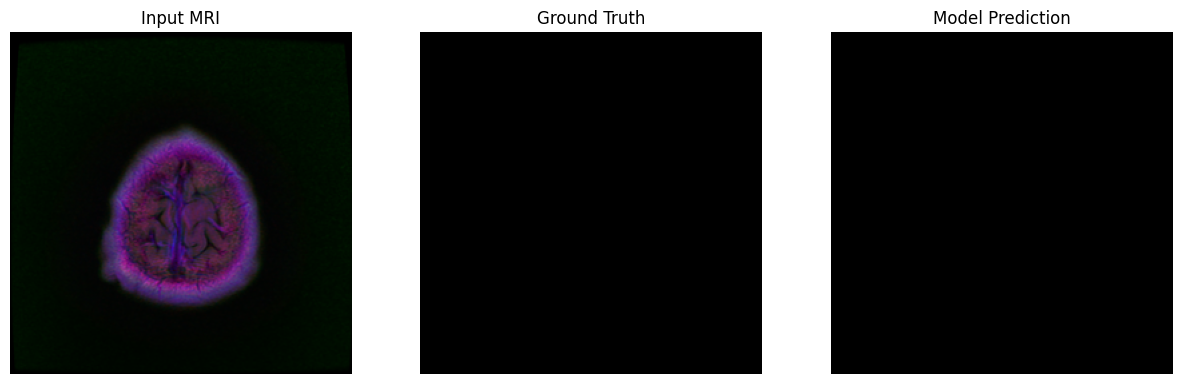

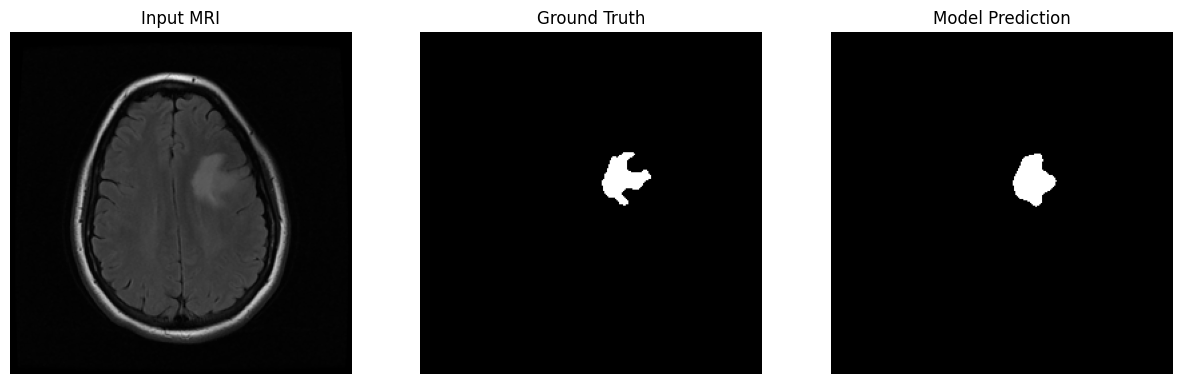

In [23]:
# 1. Create Test Dataset & Loader
# IMPORTANT: Use val_test_transform (No flips/rotations), ONLY Normalize/ToTensor
test_dataset = BrainMRIDataset(test_df, transform=val_test_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 2. Re-initialize a fresh model architecture
# (This ensures we aren't accidentally using old weights in memory)
model = UNet(n_classes=1, use_cbam=True).to(device)

# 3. Run Evaluation
final_score = evaluate_test(model, test_loader, device=device)

# 4. Visualize a few examples
# Change idx to see different patients
visualize_prediction(model, test_dataset, device, idx=5)
visualize_prediction(model, test_dataset, device, idx=10)